<a href="https://colab.research.google.com/github/dnaae/spot_detection_/blob/extract-cell-level-results/NOTEBOOK_6_FEW_HARDCODED_PARTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install big-fish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.2/123.2 kB 2.5 MB/s eta 0:00:00


In [2]:
#imports
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.multistack as multistack
import bigfish.plot as plot
from google.colab import drive
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


In [3]:
# Function to mount Google Drive and select a folder
def choose_folder_colab():
    drive.mount('/content/drive')
    drive_folder = "/content/drive/MyDrive/"
    contents = os.listdir(drive_folder)

    print("Contents of your Google Drive:")
    for i, item in enumerate(contents):
        print(f"{i + 1}: {item}")

    while True:
        choice = input("Enter the number of the folder you want to select (q to quit): ")
        if choice.lower() == 'q':
            return None
        try:
            choice = int(choice)
            if 1 <= choice <= len(contents):
                selected_folder = os.path.join(drive_folder, contents[choice - 1])
                return selected_folder
            else:
                print("Invalid choice. Please try again or enter 'q' to quit.")
        except (ValueError, KeyboardInterrupt):
            print("Invalid input. Please try again or enter 'q' to quit.")

In [24]:
def load_masks_and_data_interactive(output_folder, selected_image_index):
    original_directory = os.getcwd()  # Get the current working directory

    # Construct the path to the "output" subfolder
    output_folder = os.path.join(output_folder, 'output')

    try:
        os.chdir(output_folder)  # Change working directory to "output"

        # Print the list of files in the output folder
        directory_contents = os.listdir()
        print("Contents of the output folder:")
        for item in directory_contents:
            print(item)

        # Generate file names based on the selected image index
        cell_mask_filename = f"cellular_mask_{selected_image_index}.tif"
        nuc_mask_filename = f"nuclear_mask_{selected_image_index}.tif"
        spots_filename = f"spots_cell_{selected_image_index}.csv"
        clusters_filename = f"clusters_cell_{selected_image_index}.csv"

        # ...

        # Construct paths to the files within the "output" subfolder
        path_cell_label = os.path.join(output_folder, "cellular masks", cell_mask_filename)
        path_nuc_label = os.path.join(output_folder, "nuclear masks", nuc_mask_filename)
        path_spots = os.path.join(output_folder, "notebook 5 output", spots_filename)
        path_foci = os.path.join(output_folder, "notebook 5 output", clusters_filename)

        print("Attempting to load the following files:")
        print(f"Cell mask: {path_cell_label}")
        print(f"Nuclear mask: {path_nuc_label}")
        print(f"Spots file: {path_spots}")
        print(f"Clusters file: {path_foci}")

        if not os.path.exists(path_cell_label) or not os.path.exists(path_nuc_label) or \
                not os.path.exists(path_spots) or not os.path.exists(path_foci):
            print("One or more mask/data files not found in the specified folder.")
            return None, None, None, None

# ...

        # Load segmented cells
        cell_label = stack.read_image(path_cell_label)
        print("Segmented cells")
        print("\r shape: {0}".format(cell_label.shape))
        print("\r dtype: {0}".format(cell_label.dtype), "\n")

        # Load segmented nuclei
        nuc_label = stack.read_image(path_nuc_label)
        print("Segmented nuclei")
        print("\r shape: {0}".format(nuc_label.shape))
        print("\r dtype: {0}".format(nuc_label.dtype), "\n")

        # Load detected spots
        spots = stack.read_array_from_csv(path_spots, dtype=np.int64)
        print("Detected spots")
        print("\r shape: {0}".format(spots.shape))
        print("\r dtype: {0}".format(spots.dtype), "\n")

        # Load detected clusters/foci
        clusters = stack.read_array_from_csv(path_foci, dtype=np.int64)
        print("Detected clusters/foci")
        print("\r shape: {0}".format(clusters.shape))
        print("\r dtype: {0}".format(clusters.dtype), "\n")

        return cell_label, nuc_label, spots, clusters
    finally:
        os.chdir(original_directory)  # Change working directory back to the original path


In [5]:
def discriminate_foci_transcription_sites(spots, clusters, nuc_label):
    spots_no_ts, foci, ts = multistack.remove_transcription_site(spots, clusters, nuc_label, ndim=3)
    return spots_no_ts, foci, ts

def identify_objects(spots, nuc_label):
    spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
    return spots_in, spots_out

def cell_extraction(cell_label, nuc_label, spots_no_ts, foci, ts, image_contrasted, nuc_mip, rna_mip):
    fov_results = multistack.extract_cell(
        cell_label=cell_label,
        ndim=3,
        nuc_label=nuc_label,
        rna_coord=spots_no_ts,
        others_coord={"foci": foci, "transcription_site": ts},
        image=image_contrasted,
        others_image={"dapi": nuc_mip, "smfish": rna_mip}
    )
    return fov_results




In [6]:
def process_and_plot_cells(fov_results):
    for i, cell_results in enumerate(fov_results):
        print("cell {0}".format(i))

        # get cell results
        cell_mask = cell_results["cell_mask"]
        cell_coord = cell_results["cell_coord"]
        nuc_mask = cell_results["nuc_mask"]
        nuc_coord = cell_results["nuc_coord"]
        rna_coord = cell_results["rna_coord"]
        foci_coord = cell_results["foci"]
        ts_coord = cell_results["transcription_site"]
        image_contrasted = cell_results["image"]
        print("\r number of rna {0}".format(len(rna_coord)))
        print("\r number of foci {0}".format(len(foci_coord)))
        print("\r number of transcription sites {0}".format(len(ts_coord)))

        # plot cell
        plot.plot_cell(
            ndim=3, cell_coord=cell_coord, nuc_coord=nuc_coord,
            rna_coord=rna_coord, foci_coord=foci_coord, other_coord=ts_coord,
            image=image_contrasted, cell_mask=cell_mask, nuc_mask=nuc_mask,
            title="Cell {0}".format(i))



In [11]:
def save_extraction_results(fov_results, path_output):
    output_folder = os.path.join(path_output, 'output')  # Construct the path to the "output" subfolder
    os.makedirs(output_folder, exist_ok=True)  # Create the "output" subfolder if it doesn't exist

    os.chdir(output_folder)  # Change the working directory to the "output" subfolder

    # Summarize extraction results
    df = multistack.summarize_extraction_results(fov_results, ndim=3)
    print("Shape: {0}".format(df.shape))
    df.head()

    # Create the "extraction_results_csv" directory in the "output" subfolder if it doesn't exist
    extraction_results_dir = os.path.join(output_folder, "extraction_results_csv_notebook6")
    os.makedirs(extraction_results_dir, exist_ok=True)

    # Save individual cell results
    for i, cell_results in enumerate(fov_results, start=1):
        # Save results for each cell in the "cell_i" subfolder
        #cell_output_dir = os.path.join(extraction_results_dir, f"cell_{i}")
        cell_output_dir = os.path.join(extraction_results_dir)
        os.makedirs(cell_output_dir, exist_ok=True)

        # Generate dynamic file names based on the cell number
        csv_file_path = os.path.join(cell_output_dir, f"extraction_results_cell_{i}.csv")
        npz_file_path = os.path.join(cell_output_dir, f"results_cell_{i}.npz")

        # Save the DataFrame to a CSV file in the "cell_i" subfolder
        df.to_csv(csv_file_path, index=False)

        # Save the results in a .npz file in the "cell_i" subfolder
        stack.save_cell_extracted(cell_results, npz_file_path)

    # Reset the working directory back to the original path
    os.chdir(path_output)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: CPTH2
9: 5-AZA
10: DMSO
11: FULV
12: experiment_1_dapi_fov_1.tif
13: experiment_1_smfish_fov_1.tif
14: example_nuc_full.tif
15: example_cell_full.tif
Enter the number of the folder you want to select (q to quit): 8
Selected folder: /content/drive/MyDrive/CPTH2/output
Subfolders:
1: nuclear masks
2: cellular masks
3: splitted images
4: extraction_results_csv_notebook6
5: notebook 5 output
Enter the number of the subfolder you want to select (0 for current folder): 3
Available DAPI channels:
1: MCF7_AREG_CPTH2_501.tif_C1.tif
2: MCF7_AREG_CPTH2_505.tif_C1.tif
3: MCF7_AREG_CPTH2_509.tif_C1.tif
4: MCF7_AREG_CPTH2_506.tif_C1.tif
5: MCF7_AREG_CPTH2_504.tif_C1.tif
6: MCF7_AREG

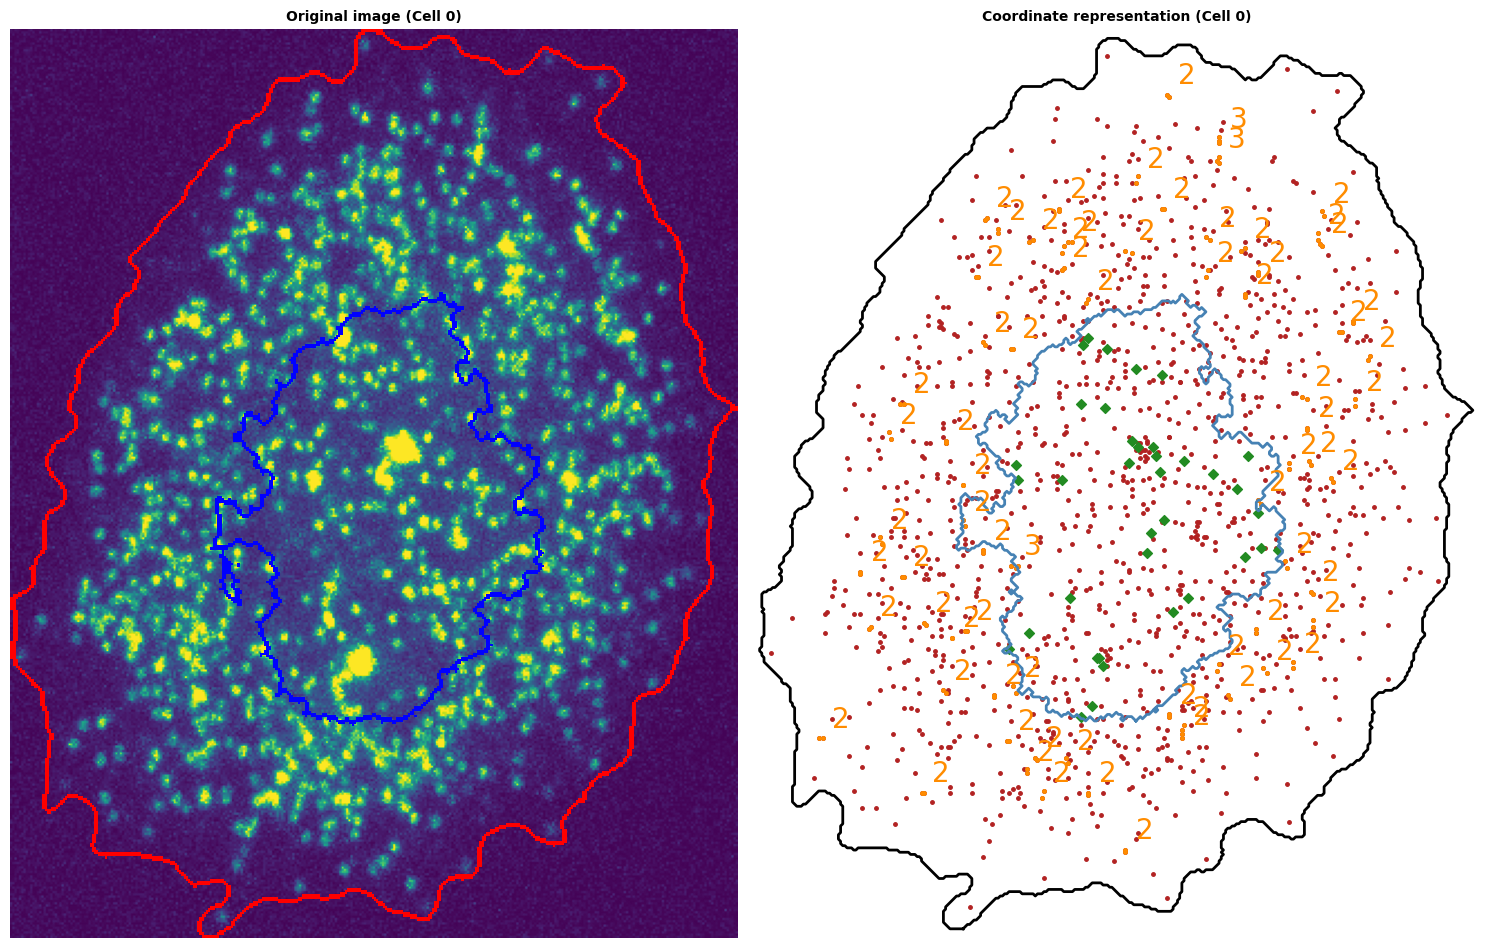

Shape: (1, 8)


In [25]:
def process_images_interactively(path_output):
    global image_contrasted, nuc_mip, rna_mip
    output_folder = os.path.join(path_output, 'output')  # Construct the path to the "output" subfolder
    os.chdir(output_folder)  # Change the working directory to the "output" subfolder

    # Now, you can guide the user in the "output" subfolder
    print(f"Selected folder: {output_folder}")

    # Allow the user to choose a subfolder interactively
    subfolders = [f for f in os.listdir() if os.path.isdir(f)]
    print("Subfolders:")
    for i, subfolder in enumerate(subfolders):
        print(f"{i + 1}: {subfolder}")

    selected_subfolder_index = int(input("Enter the number of the subfolder you want to select (0 for current folder): ")) - 1

    if selected_subfolder_index >= 0 and selected_subfolder_index < len(subfolders):
        selected_subfolder = subfolders[selected_subfolder_index]
        os.chdir(selected_subfolder)  # Change the working directory to the selected subfolder

    # List available channel images
    available_channels = [f for f in os.listdir() if f.endswith("_C1.tif") or f.endswith("_C2.tif")]

    # Separate DAPI and FISH channels
    dapi_channels = [channel for channel in available_channels if "_C1.tif" in channel]
    fish_channels = [channel for channel in available_channels if "_C2.tif" in channel]

    print("Available DAPI channels:")
    for i, dapi_channel in enumerate(dapi_channels):
        print(f"{i + 1}: {dapi_channel}")

    selected_dapi_index = int(input("Enter the number of the DAPI channel you want to select: ")) - 1

    print("Available FISH channels:")
    for i, fish_channel in enumerate(fish_channels):
        print(f"{i + 1}: {fish_channel}")

    selected_fish_index = int(input("Enter the number of the FISH channel you want to select: ")) - 1

    if (
        0 <= selected_dapi_index < len(dapi_channels) and
        0 <= selected_fish_index < len(fish_channels)
    ):
        selected_dapi_image = dapi_channels[selected_dapi_index]
        selected_fish_image = fish_channels[selected_fish_index]

        print(f"Selected DAPI image: {selected_dapi_image}")
        print(f"Selected FISH image: {selected_fish_image}")

        # Automatically generate file names for channels based on the selected index
        nuc_filename = selected_dapi_image
        rna_filename = selected_fish_image

        # Construct the full paths to the images within the "output" subfolder
        nuc_path = os.path.join(output_folder, selected_subfolder, nuc_filename)
        rna_path = os.path.join(output_folder, selected_subfolder, rna_filename)


        if not os.path.exists(nuc_path) or not os.path.exists(rna_path):
            print("Image files not found in the specified folder.")
            return

        # Process the nucleus channel
        nuc = stack.read_image(nuc_path)
        nuc_mip = stack.maximum_projection(nuc)

        print("Nucleus channel")
        print("\r shape: {0}".format(nuc.shape))
        print("\r dtype: {0}".format(nuc.dtype), "\n")

        # Process the FISH channel
        rna = stack.read_image(rna_path)
        rna_mip = stack.maximum_projection(rna)

        print("FISH channel")
        print("\r shape: {0}".format(rna.shape))
        print("\r dtype: {0}".format(rna.dtype))

        # Enhance contrast of the FISH image (rna) and create a 2D maximum projection of the contrast-enhanced image
        image_contrasted = stack.rescale(rna, channel_to_stretch=0)
        image_contrasted = stack.maximum_projection(image_contrasted)
        # image_contrasted = stack.mean_projection(image_contrasted)

        print("Image contrasted successfully.")  # Add this line

        # Reset the working directory back to the original path
        os.chdir(path_output)
    else:
        print("Invalid channel index selected.")
if __name__ == "__main__":
    # Allow the user to choose a folder interactively in Google Colab
    path_input = choose_folder_colab()

    if path_input:
        # The user selected the treatment folder, so guide them in the "output" subfolder
        process_images_interactively(path_input)

        # The user selected the treatment folder, so guide them to load masks and data interactively
        cell_label, nuc_label, spots, clusters = load_masks_and_data_interactive(path_input, selected_image_index=1)

        # Now, you can call the functions to perform the tasks
        spots_no_ts, foci, ts = discriminate_foci_transcription_sites(spots, clusters, nuc_label)
        spots_in, spots_out = identify_objects(spots_no_ts, nuc_label)
        fov_results = cell_extraction(cell_label, nuc_label, spots_no_ts, foci, ts, image_contrasted, nuc_mip, rna_mip)

        # Call the function to process and plot cells
        process_and_plot_cells(fov_results)

        # Call the function to save extraction results
        save_extraction_results(fov_results, path_input)